In [1]:
# ============================================================
# 0. Montar Drive e imports
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

import os, json, random, time
import numpy as np
import cv2
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


Mounted at /content/drive


In [2]:
# ============================================================
# 1. Paths y configuración
# ============================================================
ROOT = "/content/drive/MyDrive/proyecto_escoliosis_MAIA"
IMG_DIR = os.path.join(ROOT, "Radiografías")
COCO_JSON = os.path.join(ROOT, "Anotaciones vértebras/coco_anotaciones_actualizadas_23sep.json")

MODELS_DIR = os.path.join(ROOT, "models_unetpp")
os.makedirs(MODELS_DIR, exist_ok=True)

IMG_SIZE = 256       # 256x256 para UNet++
NUM_CLASSES = 3      # 0=Fondo, 1=V (vértebras), 2=T1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

id2label = {0: "F", 1: "V", 2: "T1"}
label2id = {v: k for k, v in id2label.items()}


Device: cuda


In [3]:
# ============================================================
# 2. Cargar COCO y filtrar sólo imágenes que existen en Radiografías
# ============================================================
with open(COCO_JSON, "r") as f:
    coco_raw = json.load(f)

print("Imágenes en COCO:", len(coco_raw["images"]))
print("Anotaciones en COCO:", len(coco_raw["annotations"]))

def filter_coco_existing(coco, img_root):
    existing = set(os.listdir(img_root))
    images_f = []
    valid_ids = set()

    for img in coco["images"]:
        fname = img.get("toras_path", img.get("file_name", "")).lstrip("/")
        base = os.path.basename(fname)
        if base in existing:
            images_f.append(img)
            valid_ids.add(img["id"])

    anns_f = [a for a in coco["annotations"] if a["image_id"] in valid_ids]

    coco_f = {
        "images": images_f,
        "annotations": anns_f,
        "categories": coco.get("categories", []),
    }
    print("Imágenes filtradas:", len(images_f))
    print("Anotaciones filtradas:", len(anns_f))
    return coco_f

coco = filter_coco_existing(coco_raw, IMG_DIR)


Imágenes en COCO: 184
Anotaciones en COCO: 564
Imágenes filtradas: 174
Anotaciones filtradas: 499


In [4]:
# ============================================================
# 3. Dataset Spine + T1 (resize 256x256, augment sencillo)
# ============================================================
def resize_img_mask(img_rgb, mask, size=256):
    img_resized = cv2.resize(img_rgb, (size, size), interpolation=cv2.INTER_AREA)
    mask_resized = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)
    return img_resized, mask_resized

def random_flip(img_rgb, mask):
    if random.random() < 0.5:
        img_rgb = np.ascontiguousarray(img_rgb[:, ::-1, :])
        mask    = np.ascontiguousarray(mask[:, ::-1])
    return img_rgb, mask

class SpineT1Dataset(Dataset):
    def __init__(self, coco, img_root, image_ids, train=True):
        self.coco = coco
        self.img_root = img_root
        self.image_ids = image_ids
        self.train = train

        self.imgid2info = {img["id"]: img for img in coco["images"]}
        self.anns_by_img = defaultdict(list)
        for a in coco["annotations"]:
            self.anns_by_img[a["image_id"]].append(a)

    def __len__(self):
        return len(self.image_ids)

    def _build_mask(self, img_id, h, w):
        mask = np.zeros((h, w), dtype=np.uint8)
        anns = self.anns_by_img.get(img_id, [])
        for ann in anns:
            name = ann.get("name")
            if name not in label2id:
                continue
            cls_id = label2id[name]
            seg = ann.get("segmentation", [])
            if not seg:
                continue

            # ignoramos RLE
            if isinstance(seg, dict):
                continue

            if isinstance(seg[0], (int, float)):  # lista plana
                seg = [seg]

            for poly in seg:
                if not poly or len(poly) < 6:
                    continue
                pts = np.array(poly, dtype=np.float32).reshape(-1, 2)
                if pts.shape[0] < 3:
                    continue
                pts = pts.astype(np.int32)
                try:
                    cv2.fillPoly(mask, [pts], cls_id)
                except cv2.error:
                    continue
        return mask

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        info = self.imgid2info[img_id]

        fname = info.get("toras_path", info.get("file_name", "")).lstrip("/")
        img_path = os.path.join(self.img_root, os.path.basename(fname))

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"No se pudo leer {img_path}")

        h, w = img.shape[:2]
        mask = self._build_mask(img_id, h, w)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_rgb, mask = resize_img_mask(img_rgb, mask, size=IMG_SIZE)

        if self.train:
            img_rgb, mask = random_flip(img_rgb, mask)

        img_rgb = img_rgb.astype(np.float32) / 255.0
        img_rgb = np.transpose(img_rgb, (2, 0, 1))   # C,H,W
        mask = mask.astype(np.int64)

        return torch.from_numpy(img_rgb), torch.from_numpy(mask)


In [5]:
# ============================================================
# 4. Split train / val + DataLoaders
# ============================================================
all_ids = [img["id"] for img in coco["images"]]
random.seed(42)
random.shuffle(all_ids)

split = int(0.8 * len(all_ids))
train_ids = all_ids[:split]
val_ids   = all_ids[split:]

train_ds = SpineT1Dataset(coco, IMG_DIR, train_ids, train=True)
val_ds   = SpineT1Dataset(coco, IMG_DIR, val_ids,   train=False)

BATCH_SIZE = 4

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=2, pin_memory=True, drop_last=False)

len(train_ds), len(val_ds)


(139, 35)

In [6]:
# ============================================================
# 5. Pérdida y métricas
# ============================================================
def dice_loss(logits, targets, num_classes, eps=1e-6):
    probs = torch.softmax(logits, dim=1)
    targets_onehot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

    dims = (0, 2, 3)
    intersection = torch.sum(probs * targets_onehot, dims)
    cardinality  = torch.sum(probs + targets_onehot, dims)
    dice = (2.0 * intersection + eps) / (cardinality + eps)

    dice_fg = dice[1:]  # ignorar fondo
    return 1.0 - dice_fg.mean()

class CombinedLoss(nn.Module):
    def __init__(self, num_classes, ce_w=0.6, dice_w=0.4, class_weights=None):
        super().__init__()
        self.ce_w = ce_w
        self.dice_w = dice_w
        self.ce = nn.CrossEntropyLoss(weight=class_weights)
        self.num_classes = num_classes

    def forward(self, logits, targets):
        ce = self.ce(logits, targets)
        d  = dice_loss(logits, targets, self.num_classes)
        return self.ce_w * ce + self.dice_w * d

def update_iou_stats(stats, preds, targets, num_classes):
    for c in range(num_classes):
        pred_c = (preds == c)
        target_c = (targets == c)
        inter = (pred_c & target_c).sum().item()
        union = (pred_c | target_c).sum().item()
        stats["inter"][c] += inter
        stats["union"][c] += union

def compute_iou_from_stats(stats):
    inter = np.array(stats["inter"], dtype=np.float64)
    union = np.array(stats["union"], dtype=np.float64)
    iou = np.zeros_like(inter, dtype=np.float64)
    valid = union > 0
    iou[valid] = inter[valid] / union[valid]
    iou[~valid] = np.nan
    return iou


In [9]:
# ============================================================
# 6. Modelo UNet++ (compacto, canales corregidos)
# ============================================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNetPP(nn.Module):
    """
    Implementación de UNet++ con profundidad 4 y base_ch (nb).
    Estructura de canales (nb = base_ch):

    X0,0: nb
    X1,0: 2nb
    X2,0: 4nb
    X3,0: 8nb
    X4,0: 16nb

    X0,1: nb      (nb + 2nb -> 3nb de entrada)
    X1,1: 2nb     (2nb + 4nb -> 6nb)
    X2,1: 4nb     (4nb + 8nb -> 12nb)
    X3,1: 8nb     (8nb +16nb -> 24nb)

    X0,2: nb      (nb + nb + 2nb -> 4nb)
    X1,2: 2nb     (2nb +2nb +4nb -> 8nb)
    X2,2: 4nb     (4nb +4nb +8nb ->16nb)

    X0,3: nb      (nb +nb +nb +2nb -> 5nb)
    X1,3: 2nb     (2nb+2nb+2nb+4nb ->10nb)

    X0,4: nb      (nb +nb +nb +nb +2nb -> 7nb)
    """
    def __init__(self, in_ch=3, num_classes=3, base_ch=32):
        super().__init__()
        nb = base_ch

        # Encoder (X_,0)
        self.conv0_0 = ConvBlock(in_ch,    nb)
        self.conv1_0 = ConvBlock(nb,       nb*2)
        self.conv2_0 = ConvBlock(nb*2,     nb*4)
        self.conv3_0 = ConvBlock(nb*4,     nb*8)
        self.conv4_0 = ConvBlock(nb*8,     nb*16)

        self.pool = nn.MaxPool2d(2)

        # X_,1
        self.conv0_1 = ConvBlock(nb + nb*2,      nb)      # 3nb in
        self.conv1_1 = ConvBlock(nb*2 + nb*4,    nb*2)    # 6nb in
        self.conv2_1 = ConvBlock(nb*4 + nb*8,    nb*4)    # 12nb in
        self.conv3_1 = ConvBlock(nb*8 + nb*16,   nb*8)    # 24nb in

        # X_,2
        self.conv0_2 = ConvBlock(nb + nb + nb*2, nb)      # 4nb in
        self.conv1_2 = ConvBlock(nb*2 + nb*2 + nb*4,
                                 nb*2)                    # 8nb in
        self.conv2_2 = ConvBlock(nb*4 + nb*4 + nb*8,
                                 nb*4)                    # 16nb in

        # X_,3
        self.conv0_3 = ConvBlock(nb + nb + nb + nb*2,
                                 nb)                      # 5nb in
        self.conv1_3 = ConvBlock(nb*2 + nb*2 + nb*2 + nb*4,
                                 nb*2)                    # 10nb in

        # X0,4
        self.conv0_4 = ConvBlock(nb + nb + nb + nb + nb*2,
                                 nb)                      # 7nb in

        self.final = nn.Conv2d(nb, num_classes, kernel_size=1)

    def forward(self, x):
        nb = 1  # solo para recordar las escalas en los comentarios

        # Encoder
        x0_0 = self.conv0_0(x)               # nb
        x1_0 = self.conv1_0(self.pool(x0_0)) # 2nb
        x2_0 = self.conv2_0(self.pool(x1_0)) # 4nb
        x3_0 = self.conv3_0(self.pool(x2_0)) # 8nb
        x4_0 = self.conv4_0(self.pool(x3_0)) #16nb

        # Nivel 1
        x0_1 = self.conv0_1(torch.cat([
            x0_0,
            F.interpolate(x1_0, scale_factor=2, mode="bilinear", align_corners=False)
        ], dim=1))
        x1_1 = self.conv1_1(torch.cat([
            x1_0,
            F.interpolate(x2_0, scale_factor=2, mode="bilinear", align_corners=False)
        ], dim=1))
        x2_1 = self.conv2_1(torch.cat([
            x2_0,
            F.interpolate(x3_0, scale_factor=2, mode="bilinear", align_corners=False)
        ], dim=1))
        x3_1 = self.conv3_1(torch.cat([
            x3_0,
            F.interpolate(x4_0, scale_factor=2, mode="bilinear", align_corners=False)
        ], dim=1))

        # Nivel 2
        x0_2 = self.conv0_2(torch.cat([
            x0_0, x0_1,
            F.interpolate(x1_1, scale_factor=2, mode="bilinear", align_corners=False)
        ], dim=1))
        x1_2 = self.conv1_2(torch.cat([
            x1_0, x1_1,
            F.interpolate(x2_1, scale_factor=2, mode="bilinear", align_corners=False)
        ], dim=1))
        x2_2 = self.conv2_2(torch.cat([
            x2_0, x2_1,
            F.interpolate(x3_1, scale_factor=2, mode="bilinear", align_corners=False)
        ], dim=1))

        # Nivel 3
        x0_3 = self.conv0_3(torch.cat([
            x0_0, x0_1, x0_2,
            F.interpolate(x1_2, scale_factor=2, mode="bilinear", align_corners=False)
        ], dim=1))
        x1_3 = self.conv1_3(torch.cat([
            x1_0, x1_1, x1_2,
            F.interpolate(x2_2, scale_factor=2, mode="bilinear", align_corners=False)
        ], dim=1))

        # Nivel 4
        x0_4 = self.conv0_4(torch.cat([
            x0_0, x0_1, x0_2, x0_3,
            F.interpolate(x1_3, scale_factor=2, mode="bilinear", align_corners=False)
        ], dim=1))

        logits = self.final(x0_4)
        return logits

# Instanciar modelo
model = UNetPP(in_ch=3, num_classes=NUM_CLASSES, base_ch=32).to(device)
print("Parámetros (M):", sum(p.numel() for p in model.parameters())/1e6)


Parámetros (M): 9.159747


In [12]:
# ============================================================
# 7. Entrenamiento UNet++
# ============================================================
class_weights = torch.tensor([0.05, 1.0, 3.0], dtype=torch.float32).to(device)
criterion = CombinedLoss(NUM_CLASSES, ce_w=0.5, dice_w=0.5, class_weights=class_weights)

LR = 3e-4
EPOCHS = 100

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

history = {
    "epoch": [],
    "val_iou_t1": [],
    "val_iou_v": [],
    "val_miou": [],
    "val_dice": [],
}

best_val_miou = 0.0
best_model_path = os.path.join(MODELS_DIR, "model_unetpp_spine_t1.pth")
start_time = time.time()

for epoch in range(1, EPOCHS+1):

    # -------- TRAIN --------
    model.train()
    train_loss = 0.0
    train_stats = {"inter": [0]*NUM_CLASSES, "union": [0]*NUM_CLASSES}

    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(logits, dim=1)
        update_iou_stats(train_stats, preds.cpu(), masks.cpu(), NUM_CLASSES)

    train_loss /= len(train_loader.dataset)
    train_ious = compute_iou_from_stats(train_stats)
    train_miou = np.nanmean(train_ious[1:])

    # -------- VAL --------
    model.eval()
    val_loss = 0.0
    val_stats = {"inter": [0]*NUM_CLASSES, "union": [0]*NUM_CLASSES}
    val_dice_acc = 0.0
    val_samples = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            loss = criterion(logits, masks)
            val_loss += loss.item() * imgs.size(0)

            preds = torch.argmax(logits, dim=1)
            update_iou_stats(val_stats, preds.cpu(), masks.cpu(), NUM_CLASSES)

            batch_dice = 1.0 - dice_loss(logits, masks, NUM_CLASSES).item()
            val_dice_acc += batch_dice * imgs.size(0)
            val_samples  += imgs.size(0)

    val_loss /= len(val_loader.dataset)
    val_ious = compute_iou_from_stats(val_stats)
    val_miou = np.nanmean(val_ious[1:])
    val_dice = val_dice_acc / max(1, val_samples)

    iou_f  = val_ious[label2id["F"]]
    iou_v  = val_ious[label2id["V"]]
    iou_t1 = val_ious[label2id["T1"]]

    history["epoch"].append(epoch)
    history["val_iou_t1"].append(iou_t1)
    history["val_iou_v"].append(iou_v)
    history["val_miou"].append(val_miou)
    history["val_dice"].append(val_dice)

    scheduler.step()

    print(f"Epoch [{epoch}/{EPOCHS}] "
          f"TrainLoss: {train_loss:.4f}  ValLoss: {val_loss:.4f}  "
          f"Train mIoU(no F): {train_miou:.4f}  Val mIoU(no F): {val_miou:.4f}")
    print("  Val IoU por clase:")
    for cid, iou in enumerate(val_ious):
        print(f"    {cid} ({id2label[cid]}): {iou:.4f}")
    print(f"  Val Dice: {val_dice:.4f}")

    if val_miou > best_val_miou:
        best_val_miou = val_miou
        torch.save(model.state_dict(), best_model_path)
        print(f"  -> Nuevo mejor modelo guardado en {best_model_path}")

print("Entrenamiento terminado. Mejor mIoU val (sin fondo):", best_val_miou)
total_time_min = (time.time() - start_time) / 60.0
print(f"Tiempo total: {total_time_min:.2f} min")


Epoch [1/100] TrainLoss: 0.2032  ValLoss: 0.3538  Train mIoU(no F): 0.6766  Val mIoU(no F): 0.5470
  Val IoU por clase:
    0 (F): 0.9361
    1 (V): 0.6320
    2 (T1): 0.4621
  Val Dice: 0.6575
  -> Nuevo mejor modelo guardado en /content/drive/MyDrive/proyecto_escoliosis_MAIA/models_unetpp/model_unetpp_spine_t1.pth
Epoch [2/100] TrainLoss: 0.1649  ValLoss: 0.3601  Train mIoU(no F): 0.7023  Val mIoU(no F): 0.4956
  Val IoU por clase:
    0 (F): 0.9207
    1 (V): 0.5941
    2 (T1): 0.3970
  Val Dice: 0.6121
Epoch [3/100] TrainLoss: 0.1477  ValLoss: 0.3079  Train mIoU(no F): 0.7300  Val mIoU(no F): 0.5780
  Val IoU por clase:
    0 (F): 0.9469
    1 (V): 0.6786
    2 (T1): 0.4775
  Val Dice: 0.6848
  -> Nuevo mejor modelo guardado en /content/drive/MyDrive/proyecto_escoliosis_MAIA/models_unetpp/model_unetpp_spine_t1.pth
Epoch [4/100] TrainLoss: 0.1427  ValLoss: 0.3005  Train mIoU(no F): 0.7229  Val mIoU(no F): 0.5917
  Val IoU por clase:
    0 (F): 0.9459
    1 (V): 0.6741
    2 (T1): 0.

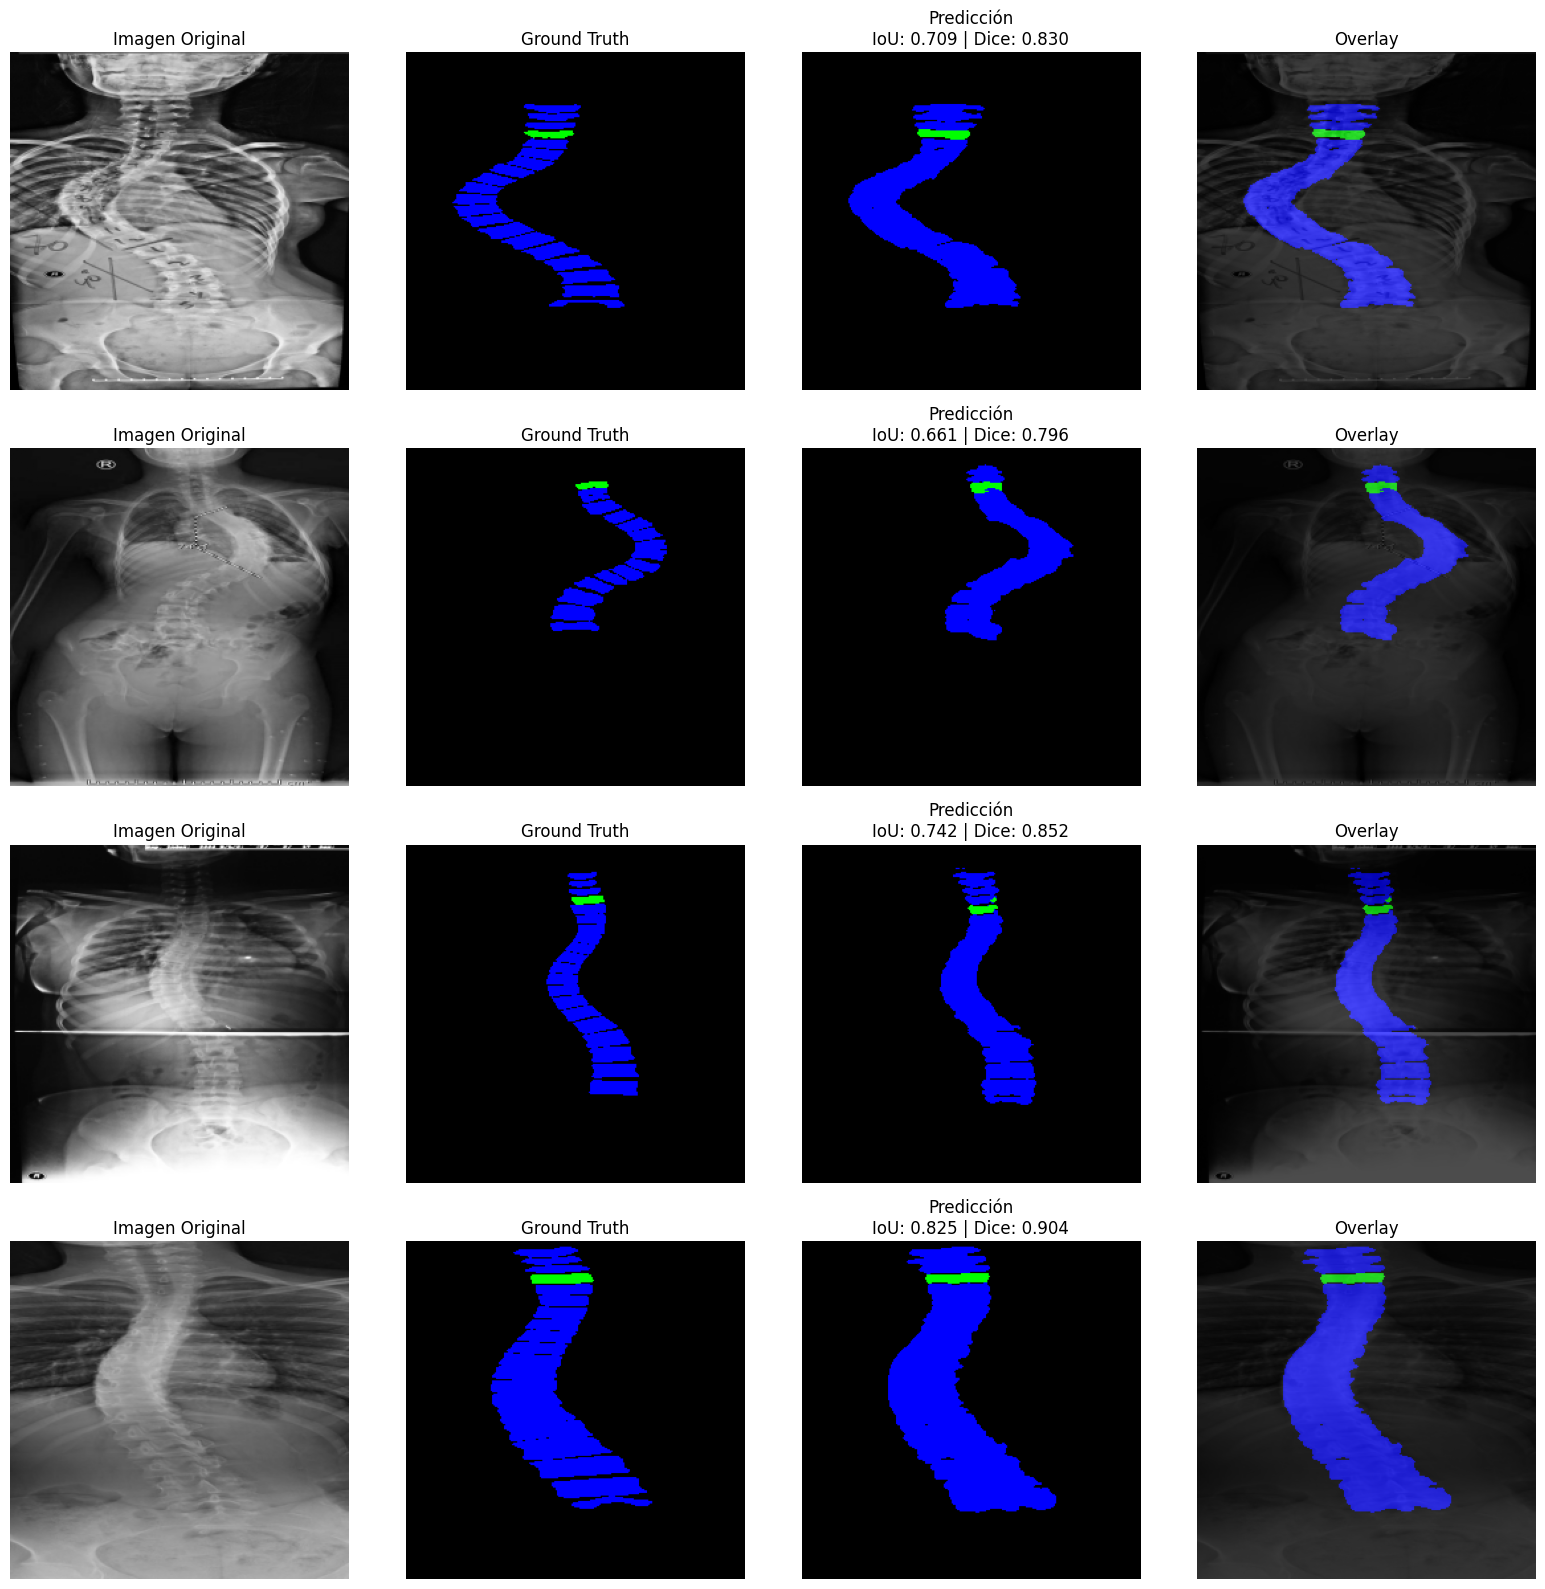

In [13]:
# ============================================================
# 8. Visualización múltiple (Original, GT, Pred, Overlay)
# ============================================================
def load_best_unetpp():
    m = UNetPP(in_ch=3, num_classes=NUM_CLASSES, base_ch=32).to(device)
    state = torch.load(best_model_path, map_location=device)
    m.load_state_dict(state)
    m.eval()
    return m

def colorize_mask(mask_np):
    """
    mask_np: (H,W) con {0,1,2}
    Devuelve imagen RGB [0,1] con:
      - Fondo negro
      - V (columna / vértebras) en azul
      - T1 en verde
    """
    h, w = mask_np.shape
    rgb = np.zeros((h, w, 3), dtype=np.float32)
    # V en azul
    rgb[mask_np == 1] = (0.0, 0.0, 1.0)
    # T1 en verde
    rgb[mask_np == 2] = (0.0, 1.0, 0.0)
    return rgb

def overlay_seg(img_t, mask_np, alpha=0.7):
    img = img_t.numpy().transpose(1, 2, 0)   # [0,1]
    color_mask = colorize_mask(mask_np)
    overlay = (1-alpha)*img + alpha*color_mask
    overlay = np.clip(overlay, 0, 1)
    return overlay

def show_panel(num_samples=4, dataset=val_ds):
    model_inf = load_best_unetpp()

    idxs = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    cols = 4
    rows = len(idxs)
    plt.figure(figsize=(cols*4, rows*4))

    for r, idx in enumerate(idxs):
        img_t, mask_gt = dataset[idx]
        with torch.no_grad():
            logits = model_inf(img_t.unsqueeze(0).to(device))
            pred = torch.argmax(logits, dim=1).squeeze(0).cpu()

        # IoU y Dice por ejemplo (solo columna+T1)
        gt_np = mask_gt.numpy()
        pred_np = pred.numpy()
        inter = np.logical_and(gt_np > 0, pred_np > 0).sum()
        union = np.logical_or(gt_np > 0, pred_np > 0).sum()
        iou_sample = inter / union if union > 0 else 0.0

        inter_d = 2 * inter
        denom_d = (gt_np > 0).sum() + (pred_np > 0).sum()
        dice_sample = inter_d / denom_d if denom_d > 0 else 0.0

        # Col 1: imagen original
        plt.subplot(rows, cols, r*cols + 1)
        plt.imshow(img_t.numpy().transpose(1, 2, 0), cmap="gray")
        plt.title("Imagen Original")
        plt.axis("off")

        # Col 2: GT
        plt.subplot(rows, cols, r*cols + 2)
        plt.imshow(colorize_mask(gt_np))
        plt.title("Ground Truth")
        plt.axis("off")

        # Col 3: Pred + métricas
        plt.subplot(rows, cols, r*cols + 3)
        plt.imshow(colorize_mask(pred_np))
        plt.title(f"Predicción\nIoU: {iou_sample:.3f} | Dice: {dice_sample:.3f}")
        plt.axis("off")

        # Col 4: Overlay
        plt.subplot(rows, cols, r*cols + 4)
        plt.imshow(overlay_seg(img_t, pred_np))
        plt.title("Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Ejemplo de panel
show_panel(num_samples=4)


In [14]:
# ============================================================
# 9. Guardar JSON de clases e info del modelo + descarga
# ============================================================
classes_info = {
    "model_name": "UNetPP_spine_T1",
    "id2label": {str(k): v for k, v in id2label.items()},
    "label2id": label2id,
    "num_classes": NUM_CLASSES,
    "img_size": [IMG_SIZE, IMG_SIZE],
    "notes": "0=Fondo, 1=Vértebras columna (todas), 2=Vértebra T1 (referencia)",
}

classes_json_path = os.path.join(MODELS_DIR, "unetpp_spine_t1_classes.json")
with open(classes_json_path, "w", encoding="utf-8") as f:
    json.dump(classes_info, f, indent=2, ensure_ascii=False)

print("Modelo guardado en:", best_model_path)
print("JSON de clases guardado en:", classes_json_path)


Modelo guardado en: /content/drive/MyDrive/proyecto_escoliosis_MAIA/models_unetpp/model_unetpp_spine_t1.pth
JSON de clases guardado en: /content/drive/MyDrive/proyecto_escoliosis_MAIA/models_unetpp/unetpp_spine_t1_classes.json
